<a href="https://www.kaggle.com/code/averma111/playground-s3e11-xgboost?scriptVersionId=124254725" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import math

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()

rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

In [6]:
train = pd.read_csv("/kaggle/input/playground-series-s3e11/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e11/test.csv")
original = pd.read_csv("/kaggle/input/media-campaign-cost-prediction/train_dataset.csv")

In [24]:
cat_cols = ["unit_sales(in millions)", "total_children", "num_children_at_home", "avg_cars_at home(approx).1", "recyclable_package",
"low_fat", "store_sqft", "coffee_bar", "video_store", "salad_bar", "prepared_food"]

In [25]:
df_full = pd.concat([train, original])
for col in cat_cols:
    df_full[col] = df_full[col].astype('int64')

In [15]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    return summ

## Statistics for datasets


In [26]:
summary('full',df_full)

full shape: (411699, 17)


,dtypes,null,unique,min,median,max,mean,std
id,float64,51363,360336,0.00,180167.50,360335.00,180167.500000,104020.187637
store_sales(in millions),float64,0,1049,0.51,5.80,22.92,6.361631,3.328577
unit_sales(in millions),int64,0,6,1.00,3.00,6.00,3.049784,0.790272
total_children,int64,0,6,0.00,2.00,5.00,2.466666,1.489275
num_children_at_home,int64,0,6,0.00,0.00,5.00,0.707184,1.227098
avg_cars_at home(approx).1,int64,0,5,0.00,2.00,4.00,2.203265,1.087416
gross_weight,float64,0,384,6.00,13.60,21.90,13.820005,4.615743
recyclable_package,int64,0,2,0.00,1.00,1.00,0.566883,0.495507
low_fat,int64,0,2,0.00,0.00,1.00,0.330710,0.470469
units_per_case,float64,0,36,1.00,20.00,36.00,18.958215,10.219328


In [17]:
summary('test',test)

test shape: (240224, 16)


,dtypes,null,unique,min,median,max,mean,std
id,int64,0,240224,360336.00,480447.5,600559.00,480447.500000,69346.839870
store_sales(in millions),float64,0,1035,0.51,5.8,22.92,6.353813,3.307402
unit_sales(in millions),float64,0,6,1.00,3.0,6.00,3.043930,0.782982
total_children,float64,0,6,0.00,2.0,5.00,2.454039,1.487416
num_children_at_home,float64,0,6,0.00,0.0,5.00,0.685381,1.211368
avg_cars_at home(approx).1,float64,0,5,0.00,2.0,4.00,2.198173,1.085129
gross_weight,float64,0,380,6.00,13.6,21.90,13.828380,4.623458
recyclable_package,float64,0,2,0.00,1.0,1.00,0.565747,0.495660
low_fat,float64,0,2,0.00,0.0,1.00,0.326928,0.469092
units_per_case,float64,0,36,1.00,20.0,36.00,18.959933,10.216219


## Univariate Analysis

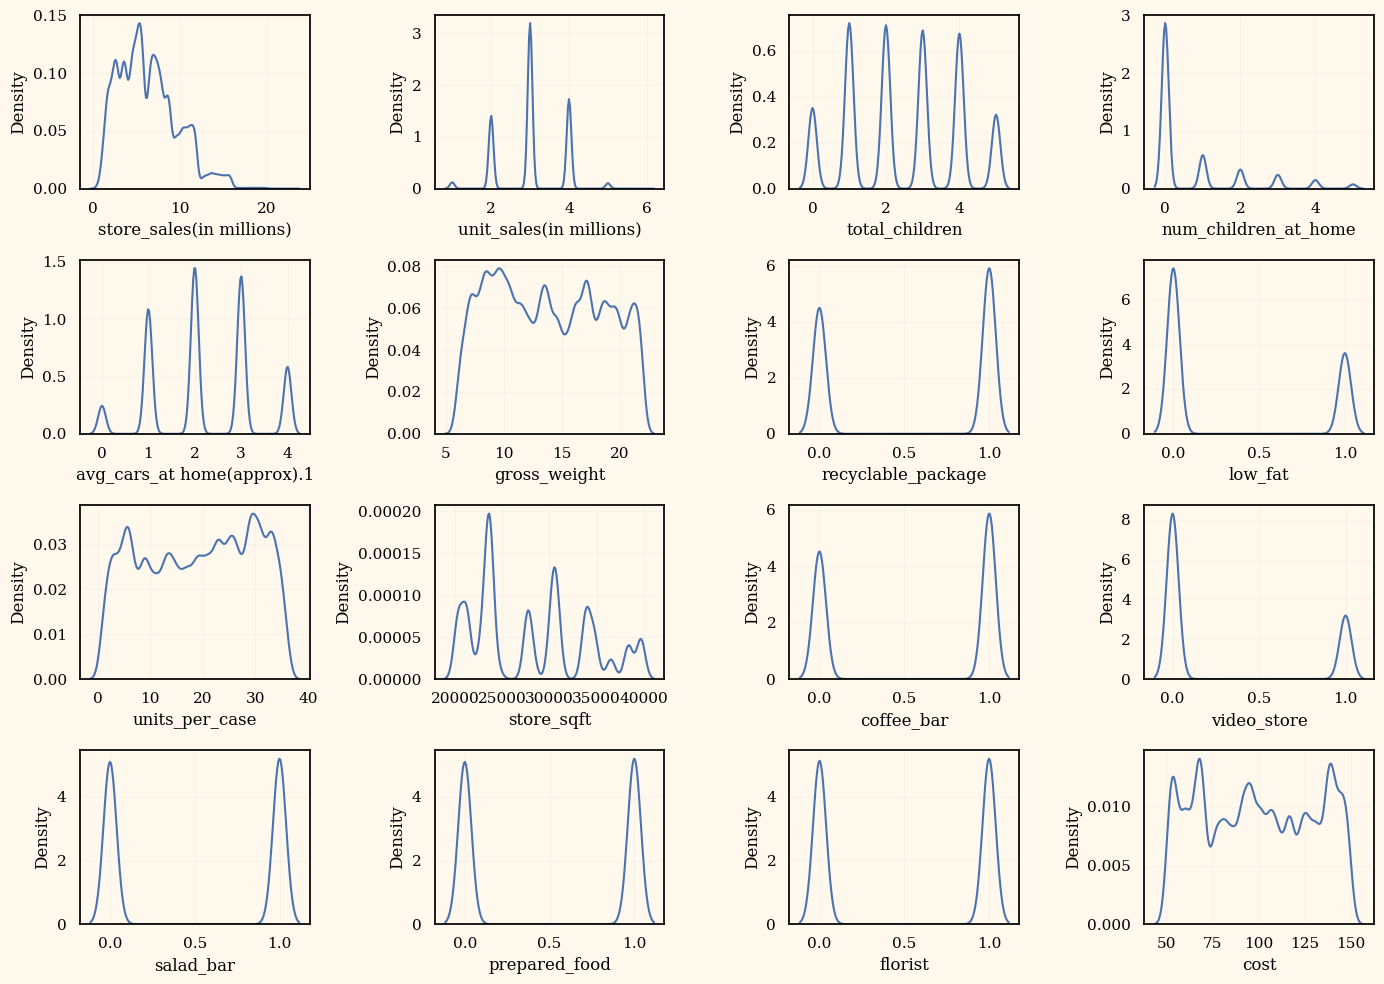

In [27]:
plt.figure(figsize=(14,10))
for i in range(1, len(df_full.columns)):
    plt.subplot(4,4,i)
    sns.kdeplot(x=train[train.columns[i]], label='Full Dataset')
    plt.tight_layout()

## Categorical Columns 


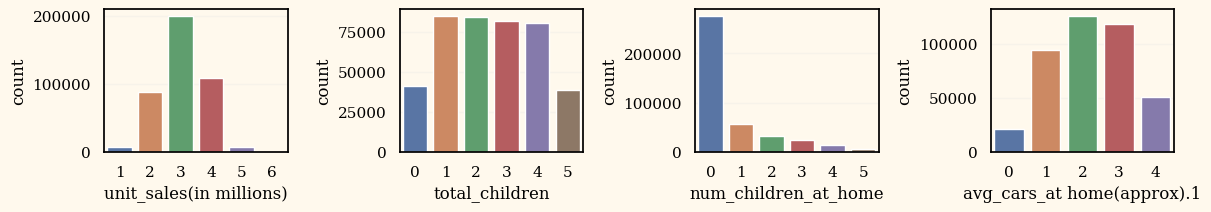

In [28]:
cats = [df_full.columns[col] for col in [2,3,4,5,7,8,11,12,13,14,15]]
plt.figure(figsize=(12,6))
for i in range(0,len(cats[:4])):
    plt.subplot(3,4,i+1)
    sns.countplot(x=df_full[cats[i]])
    plt.tight_layout()

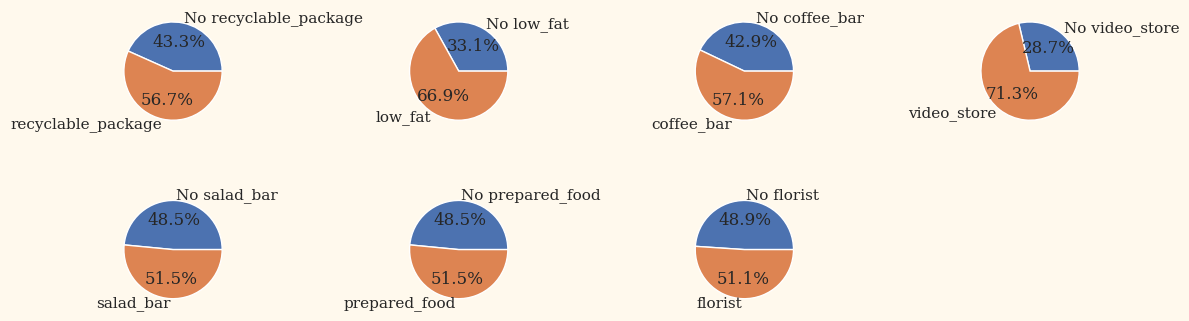

In [29]:
plt.figure(figsize=(12,4))
cats_bin = cats[4:]
for i in range(0, len(cats_bin)):
    plt.subplot(2,4,i+1)
    data=df_full[cats_bin[i]].value_counts().sort_values()
    labels = [f'No {cats_bin[i]}', f'{cats_bin[i]}']
    plt.pie(data,labels=labels,autopct='%.1f%%')
    plt.tight_layout()

## Multivariate Ananlysis

<AxesSubplot:>

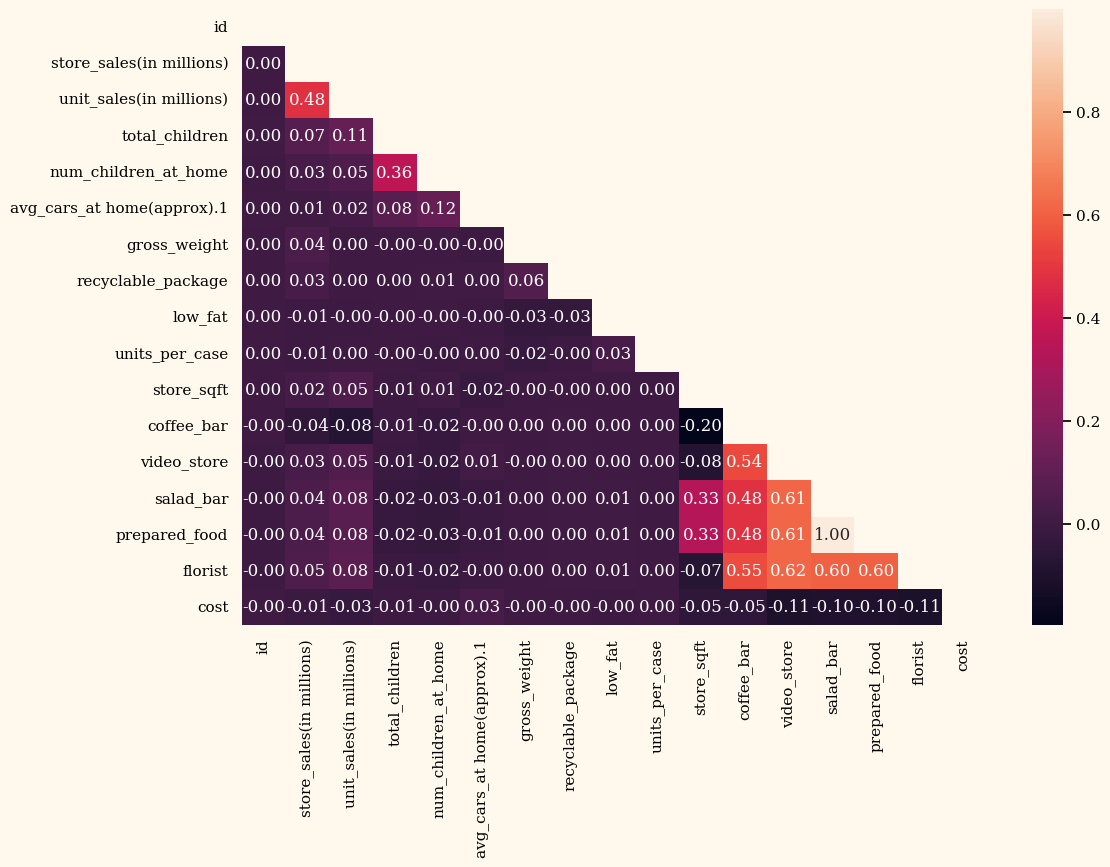

In [30]:
plt.figure(figsize=(12,8))
mask = np.triu(np.ones_like(df_full.corr()))
sns.heatmap(train.corr(), mask=mask, annot=True, fmt='.2f')

## Feature Engineering

In [31]:
df_full['children_ratio'] = df_full['num_children_at_home'] / df_full['total_children']
df_full['children_ratio'].fillna(0, inplace=True)
df_full['facilities'] = df_full['coffee_bar'] + df_full['video_store'] + df_full['salad_bar'] + df_full['florist']

In [32]:
test['children_ratio'] = test['num_children_at_home'] / test['total_children']
test['children_ratio'].fillna(0, inplace=True)
test['facilities'] = test['coffee_bar'] + test['video_store'] + test['salad_bar'] + test['florist']